# Scientific Paper Sentence Classifier (Skim Literature or SkimLit)

**Goals:** Make NLP models able to classify sentences which appear in sequential order

**Example:**
* Whole Paragraph: This is background. This is methods. This is results. This is  conclusion
* Output: **Background**: This is background; **Methods**: This is methods; **Results**: This is results; **Conclusion**: This is conclusion

**Models to Build**

* Model 1 - Conv1D with token embeddings
* Model 2 - Combining pretrained token embeddings + character embeddings (hybrid embeddings layers)
* Model 3 - Transfer Learning with pretrained token embeddings + characters embeddings + positional embeddings
* Model 4 - Tribrid model with embeddings on line number (experimental)



## Reference

Datasets:
https://arxiv.org/abs/1710.06071 (PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts)

Model: https://arxiv.org/pdf/1612.05251 (Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts)

## Get Data

In [ ]:
# Check for GPU if use
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e2ebbd4c-8cde-be7b-c567-b7c590056818)


In [ ]:
# Clone dataset from github
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!unzip /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.zip -d /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

unzip:  cannot find or open /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.zip, /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.zip.zip or /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.zip.ZIP.


We gonna use the one that replace numbers as @ for 20k Dataset

PubMed_20k_RCT_numbers_replaced_with_at_sign

In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# Create function to read the lines of a document (because data is in the form of text files)
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Look at some of lines to see if we get what we want correctly
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Preprocess Data

The raw dataset is not ready for machine learning. So we need to preprocess data

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:13]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Seems it like dictionary or array etc, lets make it in table form using pandas

**Dictionary**:

[{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]

**DataFrame**:
Column, Row with info form

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(13)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

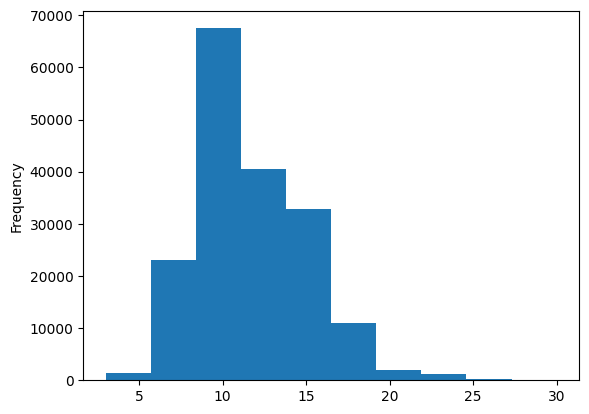

In [ ]:
# Plot distribution
train_df.total_lines.plot.hist();

Most abstract got 8 to 18 lines

### Get List of Sentences

For deep learning, input need to be in form of list of string

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

### One Hot Encoded

**Example**: Objective, Method, Conclusion

**Ono-hot Encoded**: 001, 010, 100 (In list form)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encode Labels

**Example**: Objective, Method, Conclusion

**Ono-hot Encoded**: 1, 2, 3 (In list form)

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Build Models

## Model 0: Baseline Model
Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions on test
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

### Get Helper Functions

This function was prepared in GitHub that helps do things like Confusion Matrix, Results Evaluation, Plotting etc

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-04 06:25:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-04 06:25:17 (75.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=test_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Preparing Our Data for Deep Sequence Models

Before start building deeper models, we need to create vectorization and embedding layers

Vectorization layer will convert text to numbers and embedding layer will capture relationship between those numbers

**Original:** This is sentences

**Each Word:** This -> 4 ; is -> 10 ; sentences -> 7

**Vectorization:** [4, 10, 7]

**Embedding:** [4, 14, 21] EXAMPLE!

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

When work with model, all of sentences need to be in same length (important for creating batches for same size tensors)

**Example**:
one two three four five six seven - (1,2,3,4,5,6,7)
one two three four five - (1,2,3,4,5,0,0)

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens # return average sentence length (in tokens)

26.338269273494777

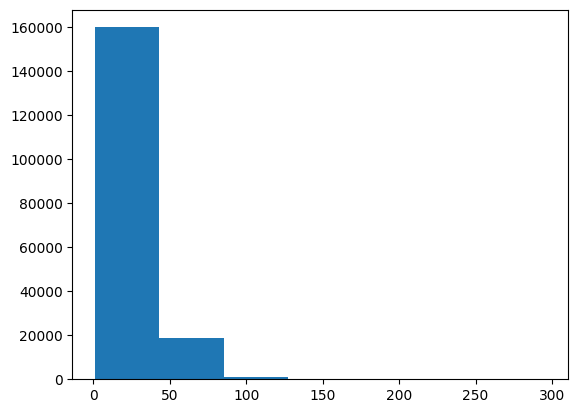

In [ ]:
# What's distribution looks like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

Majority is in between 0 to 50; On other hand, we can use NumPy's percentile to find the value which covers 95% of the sentence lengths

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

95% of the sentences in training set have length of 55 tokens or less.

When create tokenization layer, 55 will use to turn all of our sentences into the same length. Means:

**Example** Let that 55 be 5

this is five words sentence (OK)

this is multiple word sentences written here (NOT OK)

**Second sentence will be cut like this**

this is multiple word sentences

In [ ]:
# Why 95%
# Maximum sentence length in the training set
max(sent_lens)

296

Its for most of the sentences come close to 338, if we choose that 338, majority of the data pass to model will be zeros

### Create Text Vectorizer

* Turn text into numbers
* Will use `TextVectorization` layer from Tensorflow
* All parameters default except `max_tokens` (number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorizer sequence)
* Section 3.2 of PubMed 200k RCT paper states vocab size is 68,000.
* `max_tokens` = 68,000


In [ ]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

And since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our output_sequence_length parameter.

In [ ]:
# Create text vectorizer

# After TensorFlow 2.6
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
all results will be presented with @ % cis .

Length of text: 10

Vectorized text:
[[  62  117   95   36 1248    7 3040    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create Custom Text Embedding

Embedding will relates the numbers from vectorization process to make it match with deep learning model to train

As model learns, embedding will keep update to better represent the relationship between token `from vectorization`



In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
all results will be presented with @ % cis .

Sentence after vectorization (before embedding):
[[  62  117   95   36 1248    7 3040    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.01213763  0.01205367 -0.03475197 ...  0.03121997 -0.04167625
   -0.02246642]
  [ 0.01333744  0.02301648 -0.01844915 ... -0.01774381  0.0173062
   -0.03314483]
  [ 0.01142377 -0.01595105 -0.00654368 ...  0.01241659 -0.03400397
    0.0259073 ]
  ...
  [-0.03900306 -0.02865733 -0.00814277 ...  0.04292828 -0.00548706
   -0.03185411]
  [-0.03900306 -0.02865733 -0.00814277 ...  0.04292828 -0.00548706
   -0.03185411]
  [-0.03900306 -0.02865733 -0.00814277 ...  0.04292828 -0.00548706
   -0.03185411]]]

Embedded sentence shape: (1, 55, 128)


In [ ]:
vectorized_sentence.shape

TensorShape([1, 55])

### Create dataset (as fast as possible)

We need to make our dataset can be process as fast as possible. Besides, we can load our data onto GPU and run faster.

Turn our dataset into `PrefetchDataset` of batches


In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Make a modelling checkpoint

Creates a callback for saving the best version of a model during training.


In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Conv1D with token embeddings

Input (text) -> Text Vectorization -> Token Embedding -> 1D Convolution -> Global Average Pooling -> Output (label probability)

1. **Input (text)**: Raw text inputs.
2. **Text Vectorization**: Convert text to numerical vectors (using text_vectorizer).
3. **Token Embedding**: Map vectors to dense embeddings (using token_embed).
4. **1D Convolution**: Apply a 1D convolutional layer with ReLU activation to extract features from the embeddings.
5. **Global Average Pooling**: Reduce the dimensionality of the feature maps to a single vector.
6. **Output (label probability)**: Pass through a dense layer with softmax activation to produce class probabilities.

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"], )

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)), # only validate on 10% of batches
                              callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/10
562/562 [==============================] - 23s 35ms/step - loss: 0.9192 - accuracy: 0.6393 - val_loss: 0.6838 - val_accuracy: 0.7410
Epoch 2/10
562/562 [==============================] - 7s 13ms/step - loss: 0.6576 - accuracy: 0.7566 - val_loss: 0.6309 - val_accuracy: 0.7696
Epoch 3/10
562/562 [==============================] - 6s 10ms/step - loss: 0.6156 - accuracy: 0.7752 - val_loss: 0.5938 - val_accuracy: 0.7852
Epoch 4/10
562/562 [==============================] - 5s 10ms/step - loss: 0.5874 - accuracy: 0.7904 - val_loss: 0.5752 - val_accuracy: 0.7889
Epoch 5/10
562/562 [==============================] - 5s 10ms/step - loss: 0.5899 - accuracy: 0.7907 - val_loss: 0.5608 - val_accuracy: 0.7999
Epoch 6/10
562/562 [==============================] - 6s 11ms/step - loss: 0.5812 - accuracy: 0.7919 - val_loss: 0.5583 - val_accuracy: 0.7995
Epoch 7/10
562/562 [==============================] - 5s 9ms/step - loss: 0.5596 - accuracy: 0.8001 - val_loss: 0.5429 - val_accuracy: 0.8045

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_conv1d")
model_1.evaluate(valid_dataset)

945/945 [==============================] - 8s 7ms/step - loss: 0.5344 - accuracy: 0.8096


[0.5344204306602478, 0.8095789551734924]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)

# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 80.95789752416258,
 'precision': 0.8081898694813501,
 'recall': 0.8095789752416258,
 'f1': 0.8077121818960804}

## Model 2: Combining pretrained token embeddings + character embeddings (hybrid embedding layers

**Token Embeddings**

* **Input**: [This, is, sentence]
* **Process**: Each token (word) is converted into a vector through tokenization and embedding.
* **Output**: [0.11, 0.22, 0.33] (Note: This is a simplified representation. In practice, each token is represented by a vector of fixed dimensions, and the vector values will be more complex.)

**Character Embeddings**

* **Input**: [T, h, i, s, i, s, s, e, n, t, e, n, c, e]
* **Process**: Each character is converted into a vector through character-level tokenization and embedding.
* **Output**: [0.11, 0.22, 0.33, 0.44, 0.55, ...] (Again, this is a simplified representation. Each character is mapped to a vector, and the vectors will have fixed dimensions.)

**Hybrid Token and Character Embeddings**

* **Combination**: This involves creating embeddings from both tokens (words) and characters. The embeddings are then stacked or combined to represent sequences more effectively.
* **Purpose**: By using both token and character embeddings, the model can capture both higher-level semantic information and lower-level morphological information, potentially improving its understanding of the text.




### Building and Fitting an NLP Feature Extraction Model from Tensorflow Hub

Own embeddings from tokenization will take some time to run. Using pretrained token embeddings like Universal Sentences Encoding (USE) will helps fasten the time to run


In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
setipiprant at multiple oral doses was well tolerated and reduced both the allergen-induced lar and the associated ahr in allergic asthmatics .

Sentence after embedding:
[-0.05232499  0.0291269  -0.00713937 -0.01835376  0.01227455  0.03191596
  0.04769716 -0.08088586  0.07256365  0.04166634  0.08356654  0.03935719
  0.03221535  0.02852004  0.01917093 -0.02464407 -0.08917611 -0.0263683
 -0.02446153  0.05611781 -0.02464443  0.04133899 -0.07535366  0.00463894
 -0.0305976   0.02771005  0.02795554 -0.01149326 -0.02645124  0.03552767] (truncated output)...

Length of sentence embedding:
512


### Creating a character-level tokenizer

CHARACTER-LEVEL EMBEDDING

**Character Tokenization:**
* Sequences are split into individual characters. For example, the word "hello" is tokenized into the characters [h, e, l, l, o].

**Character Embeddings**
* Each character is converted into a dense vector representation. These embeddings capture the semantic and morphological properties of characters.

TOKEN-LEVEL EMBEDDINGS

**Token Tokenization**
* Sequence are split into tokens, typically words or subwords. For example, the sentences "Hello World" might be tokenized into '[Hello, World]'.

**Token Embeddings**
* Each token is mapped to a dense vector representation that captures its meaning and context. These embeddings are often used in models that handle text at a higher level of abstraction.

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

's e t i p i p r a n t   a t   m u l t i p l e   o r a l   d o s e s   w a s   w e l l   t o l e r a t e d   a n d   r e d u c e d   b o t h   t h e   a l l e r g e n - i n d u c e d   l a r   a n d   t h e   a s s o c i a t e d   a h r   i n   a l l e r g i c   a s t h m a t i c s   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

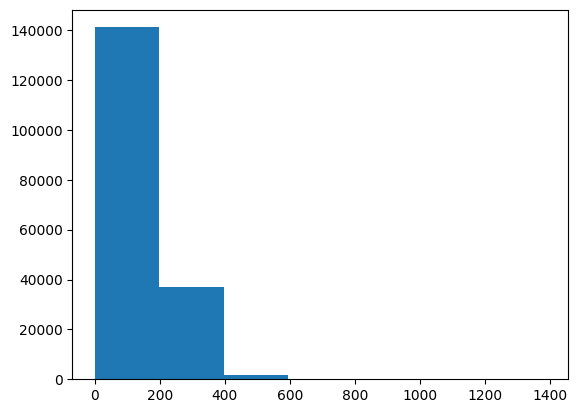

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
#Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   o b j e c t i v e   w a s   t o   a s s e s s   t h e   f e a s i b i l i t y   a n d   a c c e p t a b i l i t y   o f   n i n e   p o s i t i v e   p s y c h o l o g y   e x e r c i s e s   d e l i v e r e d   t o   p a t i e n t s   h o s p i t a l i z e d   f o r   s u i c i d a l   t h o u g h t s   o r   b e h a v i o r s   ,   a n d   t o   s e c o n d a r i l y   e x p l o r e   t h e   r e l a t i v e   i m p a c t   o f   t h e   e x e r c i s e s   .

Length of chars: 203

Vectorized chars:
[[ 3 13  2  7 22 27  2 11  3  4 21  2 20  5  9  3  7  5  9  9  2  9  9  3
  13  2 17  2  5  9  4 22  4 12  4  3 19  5  6 10  5 11 11  2 14  3  5 22
   4 12  4  3 19  7 17  6  4  6  2 14  7  9  4  3  4 21  2 14  9 19 11 13
   7 12  7 18 19  2 24  2  8 11  4  9  2  9 10  2 12  4 21  2  8  2 10  3
   7 14  5  3  4  2  6  3  9 13  7  9 14  4  3  5 12  4 25  2 10 17  7  8
   9 16  4 11  4 10  5 12  3 13  7 16 18 13  3  9  7  8 22  2 13  5 21  4
   7  8  9  5  6 10  3  7

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   o b j e c t i v e   w a s   t o   a s s e s s   t h e   f e a s i b i l i t y   a n d   a c c e p t a b i l i t y   o f   n i n e   p o s i t i v e   p s y c h o l o g y   e x e r c i s e s   d e l i v e r e d   t o   p a t i e n t s   h o s p i t a l i z e d   f o r   s u i c i d a l   t h o u g h t s   o r   b e h a v i o r s   ,   a n d   t o   s e c o n d a r i l y   e x p l o r e   t h e   r e l a t i v e   i m p a c t   o f   t h e   e x e r c i s e s   .

Embedded chars (after vectorization and embedding):
[[[ 0.03094179 -0.03211325 -0.03026075 ... -0.0490706   0.02017495
    0.03745307]
  [-0.03321262  0.02198869  0.02108553 ...  0.03372587  0.03939157
    0.04439119]
  [ 0.03292752 -0.02790389 -0.03547074 ... -0.03782593  0.03243972
   -0.00615555]
  ...
  [ 0.02049229 -0.00688971  0.03728124 ... -0.04175948 -0.03421145
   -0.00586152]
  [ 0.02049229 -0.00688971  0.03728124 ... -0.04175948 -0.03421145
   -0.00586152]

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_2 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_2_token_and_char_embeddings")

In [ ]:
# Get summary of token and character model
model_2.summary()

Model: "model_2_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

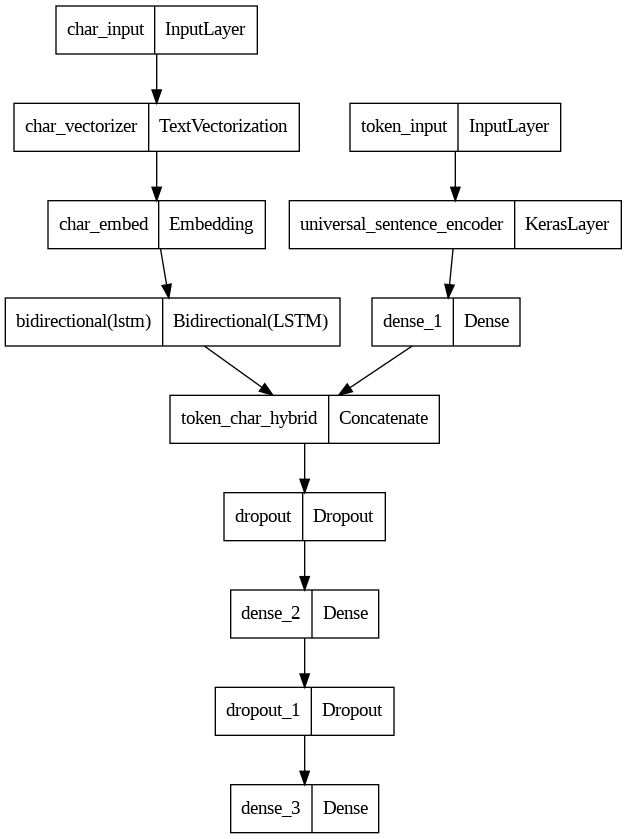

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_2)

In [ ]:
# Compile token char model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

### Combining token and character data into tf.data dataset



In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_2_history = model_2.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)),
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/3
562/562 [==============================] - 58s 86ms/step - loss: 0.9713 - accuracy: 0.6133 - val_loss: 0.7756 - val_accuracy: 0.6951
Epoch 2/3
562/562 [==============================] - 41s 72ms/step - loss: 0.7951 - accuracy: 0.6928 - val_loss: 0.7121 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 42s 76ms/step - loss: 0.7686 - accuracy: 0.7062 - val_loss: 0.6938 - val_accuracy: 0.7340


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6924 - accuracy: 0.7351


[0.6923644542694092, 0.7351052761077881]

To make predictions with it, since it takes multiplie inputs, we can pass the `predict()` method a tuple of token-level sequences and character-level sequences.

In [ ]:
# Make predictions using the token-character model hybrid
model_2_pred_probs = model_2.predict(test_char_token_dataset)
model_2_pred_probs

942/942 [==============================] - 18s 18ms/step


array([[3.22805405e-01, 2.36537218e-01, 6.52683899e-02, 3.33429396e-01,
        4.19595242e-02],
       [2.80177802e-01, 8.28516334e-02, 2.28862256e-01, 3.83808106e-01,
        2.43002400e-02],
       [1.16832077e-03, 4.34331829e-03, 9.02637959e-01, 4.59892006e-04,
        9.13905278e-02],
       ...,
       [2.43008501e-04, 2.21960172e-02, 1.51197985e-02, 5.31025144e-05,
        9.62388158e-01],
       [2.53569963e-03, 3.88711728e-02, 3.82165648e-02, 9.95259732e-04,
        9.19381320e-01],
       [2.94362027e-02, 6.61843896e-01, 1.29988626e-01, 8.38016998e-03,
        1.70351043e-01]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 72.88866766218682,
 'precision': 0.7304284346605386,
 'recall': 0.7288866766218682,
 'f1': 0.7250339068797453}

## Model 3: Transfer Learning with pretrained token embeddings + characters embeddings + positional embeddings

Token Embeddings:

* Each word or token in the sentence is converted into a corresponding vector using pretrained embeddings (USE).
* Example:
  * Sentence: ["This", "is", "sentence"]
  * Token Embedding: Each word is transformed into a vector, e.g., ["This" -> [0.11, 0.22, 0.33], "is" -> [0.44, 0.55, 0.66], "sentence" -> [0.77, 0.88, 0.99]].

**Character Embeddings**

* Each character within a token is also converted into a vector. This can help the model capture subword information, which is particularly useful for handling unknown or rare words.
* Example:
 * Word: "This"
 * Characters: ['T', 'h', 'i', 's']
 * Character Embeddings: ['T' -> [0.11, 0.22], 'h' -> [0.33, 0.44], 'i' -> [0.55, 0.66], 's' -> [0.77, 0.88]].

**Positional Embeddings**

* These embeddings represent the position of words within the text, helping the model understand the order and structure of the sentence or document.
* For instance, in an abstract, the model might learn that certain sections (e.g., Background, Objective) usually appear in specific positions. This positional information can be encoded as vectors and added to the token embeddings.
* Example:
 * If the model has learned that sentences often begin with "Objective" or "Background", it might assign a specific positional vector to the first few tokens.

In [ ]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

Note: This positional embedding should be available at test time means when we preprocess the input, it can straight get information of number of lines of certain sentences and total lines of the abstract

### Create positional embeddings

line number 5 means its not larger than 1. So we will use one-hot-encoding to encode `"line_number"` and "total_lines" features

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

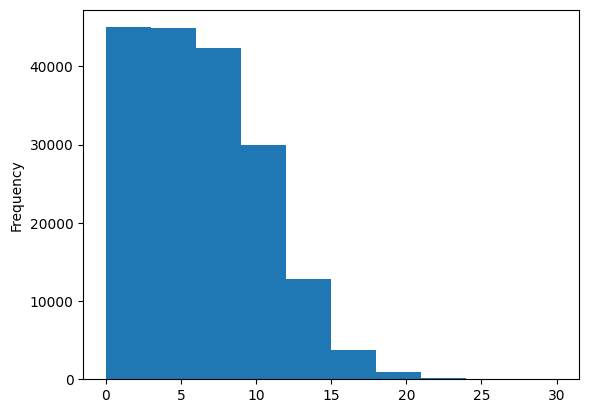

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Majority of abstract got 15 lines or less. It is important to set `depth` parameter to `tf.one_hot` to 15

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

If depth parameter is too large, model will facing difficulties if the depth parameter is has many zeros

In [ ]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

Do the same for `"total_lines"`

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

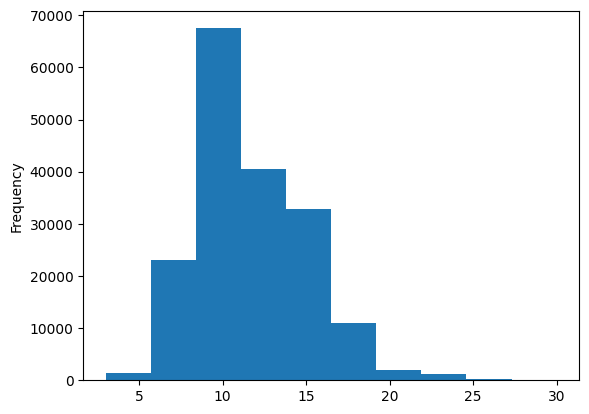

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

We can confirm this with np.percentile()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model



In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_bi_lstm = layers.Bidirectional(layers.LSTM(32))(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_bi_lstm)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_3 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary of our token, char and positional embedding model
model_3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_inputs[0][0]']        
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']   

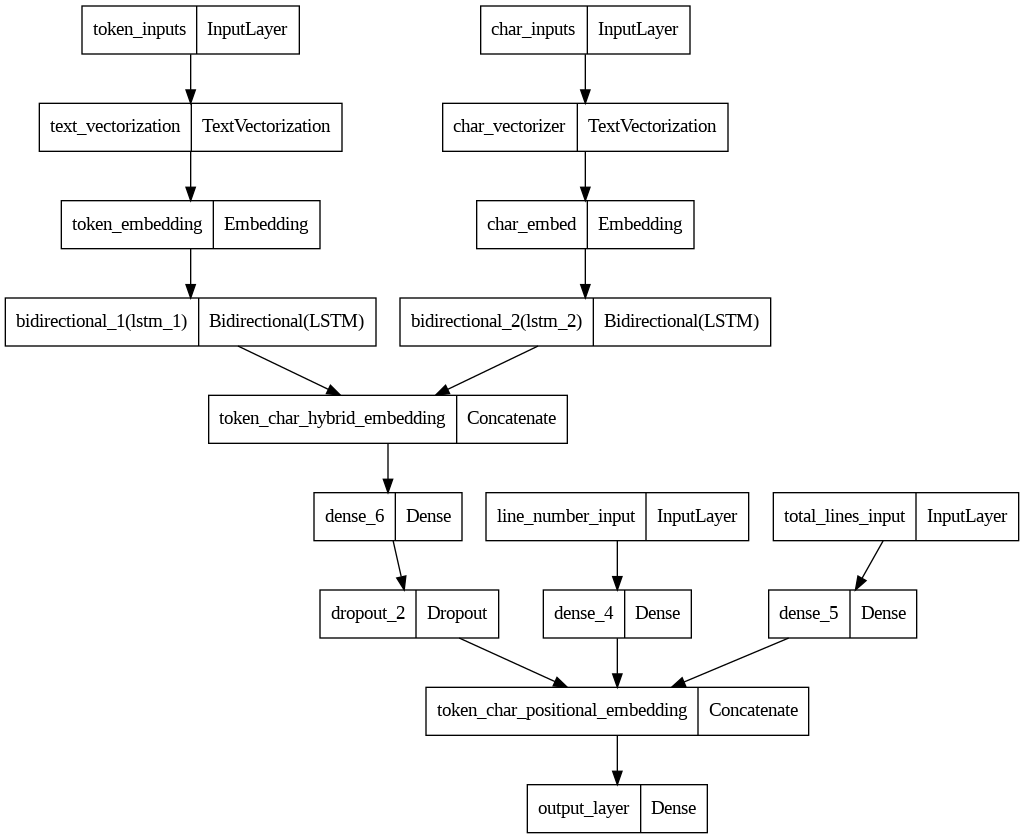

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [ ]:
# Check which layers of our model are trainable or not
for layer in model_3.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f2ec8fedf60> True
<keras.src.engine.input_layer.InputLayer object at 0x7f2ec90a4760> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f2f47796440> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f2e8829add0> True
<keras.src.layers.core.embedding.Embedding object at 0x7f2f453c5120> True
<keras.src.layers.core.embedding.Embedding object at 0x7f2e317a44c0> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7f2ec8f05cf0> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7f2ec9285f30> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7f2ec83cf370> True
<keras.src.engine.input_layer.InputLayer object at 0x7f2ec993b2e0> True
<keras.src.engine.input_layer.InputLayer object at 0x7f2e295fefb0> True
<keras.src.layers.core.dense.Dense object at 0x7f2e291dcbb0> True
<keras.src.layers.core.dense.Dense object at 0x7f2e884c

In [ ]:
# Compile token, char, positional embedding model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset`'s.

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset, test_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_3 = model_3.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                              callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/3
562/562 [==============================] - 83s 122ms/step - loss: 0.9658 - accuracy: 0.8124 - val_loss: 0.9077 - val_accuracy: 0.8388
Epoch 2/3
562/562 [==============================] - 53s 95ms/step - loss: 0.8858 - accuracy: 0.8658 - val_loss: 0.9028 - val_accuracy: 0.8411
Epoch 3/3
562/562 [==============================] - 51s 90ms/step - loss: 0.8704 - accuracy: 0.8746 - val_loss: 0.8904 - val_accuracy: 0.8541


In [ ]:
# Make predictions with token-char-positional hybrid model
model_3_pred_probs = model_3.predict(val_pos_char_token_dataset, verbose=1)


# Turn prediction probabilities into prediction classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)


# Calculate results of token-char-positional hybrid model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

945/945 [==============================] - 17s 14ms/step


{'accuracy': 85.09201641731762,
 'precision': 0.8514149193962274,
 'recall': 0.8509201641731762,
 'f1': 0.850403384736539}

## Compare Model Results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "hybrid_char_token_embed": model_2_results,
                                  "tribrid_pos_char_token_embed": model_3_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,71.667496,0.712432,0.716675,0.692510
custom_token_embed_conv1d,80.957898,0.808190,0.809579,0.807712
hybrid_char_token_embed,72.888668,0.730428,0.728887,0.725034
tribrid_pos_char_token_embed,85.092016,0.851415,0.850920,0.850403


## Model 4: Tribrid Model with better Positional Embeddings (Experimental)

In [ ]:
# Get Training DataFrame
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Copy training data for data manipulation
manipulate_df = train_df
manipulate_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Add line_of_X
manipulate_df['line_of_X'] = manipulate_df['line_number'].astype(str) + ' of ' + manipulate_df['total_lines'].astype(str)

In [ ]:
manipulate_df.head()

,target,text,line_number,total_lines,line_of_X
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0 of 11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1 of 11
2,METHODS,outcome measures included pain reduction and i...,2,11,2 of 11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3 of 11
4,METHODS,secondary outcome measures included the wester...,4,11,4 of 11


In [ ]:
# How many different numbers of lines are there?
train_df["line_of_X"].value_counts()

In [ ]:
# How many words in line_of_X ? 16
max_tokens = 33

In [ ]:
# Create Text Vectorizer for line_of_X

# After TensorFlow 2.6
from tensorflow.keras.layers import TextVectorization

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer_line = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=3) # desired output length of vectorized sequences


In [ ]:
# Add line_of_X in training, validation and test data
train_df['line_of_X'] = train_df['line_number'].astype(str) + ' of ' + train_df['total_lines'].astype(str)
val_df['line_of_X'] = val_df['line_number'].astype(str) + ' of ' + val_df['total_lines'].astype(str)
test_df['line_of_X'] = test_df['line_number'].astype(str) + ' of ' + test_df['total_lines'].astype(str)

In [ ]:
train_df.head()

In [ ]:
val_df.head()

In [ ]:
test_df.head()

In [ ]:
# Convert abstract line_of_X into lists
train_lines = train_df["line_of_X"].tolist()
val_lines = val_df["line_of_X"].tolist()
test_lines = test_df["line_of_X"].tolist()
len(train_lines), len(val_lines), len(test_lines)

In [ ]:
# View first 10 lines of training sentences
train_lines[:12]

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer_line.adapt(train_lines)

In [ ]:
# Test out text vectorizer
import random
target_lines = random.choice(train_lines)
print(f"Text:\n{target_lines}")
print(f"\nLength of text: {len(target_lines.split())}")
print(f"\nVectorized text:\n{text_vectorizer_line([target_lines])}")

In [ ]:
text_vectorizer_line([target_lines]).shape

In [ ]:
# How many words in our training vocabulary?
line_number_vocab = text_vectorizer_line.get_vocabulary()
print(f"Number of words in vocabulary: {len(line_number_vocab)}"),
print(f"Most common words in the vocabulary: {line_number_vocab[:5]}")
print(f"Least common words in the vocabulary: {line_number_vocab[-5:]}")

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 1. Line Number Token inputs
line_token_inputs = layers.Input(shape=[], dtype="string", name="line_token_inputs")
line_token_embeddings = tf_hub_embedding_layer(line_token_inputs)
line_token_outputs = layers.Dense(128, activation="relu")(line_token_embeddings)
line_token_model = tf.keras.Model(inputs=line_token_inputs,
                             outputs=line_token_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_token_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_6 = tf.keras.Model(inputs=[line_token_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
# Compile token, char, positional embedding model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_lines, # line numbers
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_lines,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

In [ ]:
# Fit the token, char and positional embedding model
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))